In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense, LSTM, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
import argparse
from joblib import dump
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

parser = argparse.ArgumentParser()

# parser.add_argument('directory', 
#                     type=str, 
#                     help = 'directory where files are stored')
# args = parser.parse_args()

# base_dir = '../data/Car Hacking Dataset/'
base_dir = './'


file_name = 'aux_attacks_new_post.csv'
data = pd.read_csv(os.path.join(base_dir, file_name))

# save_loc = os.path.join(base_dir, 'Adversarial Training Evaluation')
# os.makedirs(save_loc)

data = data.assign(IAT=data['Timestamp'].diff().fillna(0))
data.drop(['Timestamp'], axis = 1, inplace = True)

def hex_to_bin(hex_num):
    
    binary_value = bin(int(str(hex_num), 16))[2:]
    
    return binary_value

def int_to_bin(int_num):
    
    binary_value = bin(int_num)[2:]
    
    return binary_value

def pad(value, length):
    
    curr_length = len(str(value))
    
    zeros = '0' * (length - curr_length)
    
    return zeros + value

hex_to_dec = lambda x: int(x, 16)

def transform_data(data):

    data['ID'] = data['ID'].apply(hex_to_dec)
    data['Payload'] = data['Payload'].apply(hex_to_dec)

    return data

def sequencify_data(X, y, seq_size=10):
    max_index = len(X) - seq_size + 1

    X_seq = []
    y_seq = []

    for i in range(0, max_index, seq_size):
        X_seq.append(X[i:i+seq_size])  # Append the sequence from DataFrame 'X'
        y_seq.append(1 if 1 in y[i:i+seq_size] else 0)  # Check for '1' in 'y' values

    return np.array(X_seq), np.array(y_seq)

# data = transform_data(data)

In [34]:
X = data.drop('label', axis = 1)
y = data['label']

In [43]:
y_tri = y.copy(deep=True)
y = y.replace(2,1)

In [44]:
print(np.unique(y_tri, return_counts=True))
print(np.unique(y, return_counts=True))

(array([0., 1., 2.]), array([100000,  18191,  33964]))
(array([0., 1.]), array([100000,  52155]))


In [45]:
X_seq, y_seq = sequencify_data(X.values, y.values)

#Splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=True, random_state=42)
X_seq_train, X_seq_test, y_seq_train, y_seq_test = train_test_split(X_seq, y_seq, test_size = 0.2, shuffle= True)

#Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

seq_scaler = StandardScaler()
num_train_samples, seq_length, num_features = X_seq_train.shape
num_test_samples, _, _ = X_seq_test.shape

X_train_seq_reshaped = X_seq_train.reshape(num_train_samples, -1)
X_test_seq_reshaped = X_seq_test.reshape(num_test_samples, -1)

X_train_seq_scaled = seq_scaler.fit_transform(X_train_seq_reshaped)
X_test_seq_scaled = seq_scaler.transform(X_test_seq_reshaped)

# Reshape the scaled data back to the original shape
X_seq_train = X_train_seq_scaled.reshape(num_train_samples, seq_length, num_features)
X_seq_test = X_test_seq_scaled.reshape(num_test_samples, seq_length, num_features)

oversample = SMOTE()
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train) 

In [37]:
np.unique(y_test, return_counts=True)

(array([0., 1., 2.]), array([19810,  3695,  6926]))

In [38]:
test_aux_indices = y_test[y_test == 2].index
test_main_indices = y_test[y_test == 1].index

In [22]:
##Models

print("-----MLP-------")

mlp = Sequential()
mlp.add(Input(shape = (4)))
mlp.add(Dense(128, activation = 'relu'))
mlp.add(Dense(128, activation = 'relu'))
mlp.add(Dense(1, activation = 'sigmoid'))

mlp.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

es = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

mlp_hist = mlp.fit(X_train_smote, y_train_smote, epochs=100, callbacks = [es], validation_split=0.2, batch_size = 128)

##MLP
print("-----MLP-------")

threshold = 0.5
mlp_preds = mlp.predict(X_test)
mlp_preds = (mlp_preds >= threshold).astype(int)

print("ACCURACY: ", accuracy_score(y_test, mlp_preds))
print("CLASSIFICATION REPORT:\n", classification_report(y_test, mlp_preds))

# with open(os.path.join(save_loc,'train_and_eval_results.txt'),'w') as file:
#     file.write("-------MLP-------\n")
#     file.write(f"Accuracy Score: ")
#     file.write(str(accuracy_score(y_test, mlp_preds)))
#     file.write("\n")
#     file.write('Classification Report:\n')
#     file.write(str(classification_report(y_test, mlp_preds)))
#     file.write("\n\n\n\n")

# mlp.save(os.path.join(save_loc, 'mlp.h5'))

# plt.figure(figsize=(10, 10))
# plt.plot(mlp_hist.history['loss'])
# plt.plot(mlp_hist.history['val_loss'])
# plt.title('MLP Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.savefig(os.path.join(save_loc,'mlp_training_history.png'))

-----MLP-------
Epoch 1/100


2024-09-24 09:16:39.888638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1003/1003 [==============================] - ETA: 0s - loss: 0.4719 - accuracy: 0.7800

2024-09-24 09:16:45.267193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1003/1003 [==============================] - 6s 6ms/step - loss: 0.4719 - accuracy: 0.7800 - val_loss: 0.6381 - val_accuracy: 0.7037
Epoch 2/100
1003/1003 [==============================] - 5s 5ms/step - loss: 0.4389 - accuracy: 0.8014 - val_loss: 0.6029 - val_accuracy: 0.7090
Epoch 3/100
1003/1003 [==============================] - 5s 5ms/step - loss: 0.4267 - accuracy: 0.8056 - val_loss: 0.6438 - val_accuracy: 0.6073
Epoch 4/100
1003/1003 [==============================] - 5s 5ms/step - loss: 0.4180 - accuracy: 0.8092 - val_loss: 0.5607 - val_accuracy: 0.7125
Epoch 5/100
1003/1003 [==============================] - 5s 5ms/step - loss: 0.4110 - accuracy: 0.8140 - val_loss: 0.5540 - val_accuracy: 0.7169
Epoch 6/100
1003/1003 [==============================] - 5s 5ms/step - loss: 0.4038 - accuracy: 0.8166 - val_loss: 0.4835 - val_accuracy: 0.7394
Epoch 7/100
1003/1003 [==============================] - 5s 5ms/step - loss: 0.3969 - accuracy: 0.8194 - val_loss: 0.5501 - val_accuracy: 0.69

2024-09-24 09:18:24.322496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


951/951 [==============================] - 1s 1ms/step
ACCURACY:  0.8353652525385298
CLASSIFICATION REPORT:
               precision    recall  f1-score   support

         0.0       0.89      0.85      0.87     19810
         1.0       0.75      0.80      0.77     10621

    accuracy                           0.84     30431
   macro avg       0.82      0.83      0.82     30431
weighted avg       0.84      0.84      0.84     30431



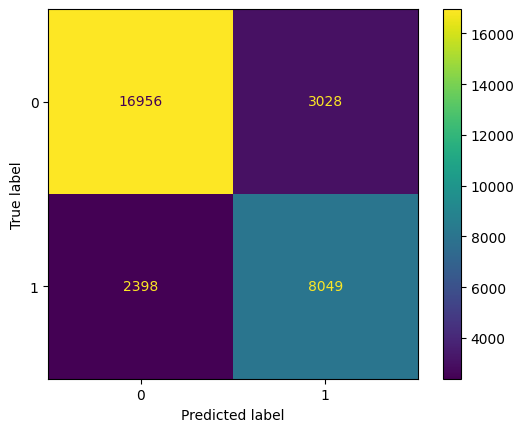

In [10]:
cm = confusion_matrix(y_test, mlp_preds)

cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])

cm_display.plot()

In [46]:
X_aux = X.iloc[test_aux_indices]
y_aux = y.iloc[test_aux_indices]
y_aux = y_aux.replace(2,1)

X_main = X.iloc[test_main_indices]
y_main = y.iloc[test_main_indices]


In [49]:
X_aux = scaler.transform(X_aux)
X_main = scaler.transform(X_main)

aux_preds = mlp.predict(X_aux)
main_preds = mlp.predict(X_main)

aux_preds = (aux_preds >= threshold).astype(int)
main_preds = (main_preds >= threshold).astype(int)

116/116 [==============================] - 0s 1ms/step


In [52]:
np.unique(y_tri, return_counts = True)

(array([0., 1., 2.]), array([100000,  18191,  33964]))

In [50]:
print(accuracy_score(y_aux, aux_preds))
print(classification_report(y_aux, aux_preds))

0.7419867167196073
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.74      0.85      6926

    accuracy                           0.74      6926
   macro avg       0.50      0.37      0.43      6926
weighted avg       1.00      0.74      0.85      6926



/Users/anwesh/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anwesh/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anwesh/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
print(accuracy_score(y_main, main_preds))
print(classification_report(y_main, main_preds))

0.9179972936400541
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.92      0.96      3695

    accuracy                           0.92      3695
   macro avg       0.50      0.46      0.48      3695
weighted avg       1.00      0.92      0.96      3695



/Users/anwesh/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anwesh/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anwesh/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
##LSTM

print("-----LSTM-------")

lstm = Sequential()

lstm.add(Input(shape = X_seq_train.shape[1:]))
lstm.add(LSTM(128, activation = 'relu'))
lstm.add(Dense(1, activation = 'sigmoid'))

lstm.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy'])

es = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

lstm_hist = lstm.fit(X_seq_train, y_seq_train, batch_size = 16, validation_split = 0.2,
        callbacks = [es], epochs = 1000)

print("-----LSTM-------")

lstm_preds = lstm.predict(X_seq_test, batch_size=4096)
lstm_preds = (lstm_preds >= threshold).astype(int)

print("ACCURACY: ", accuracy_score(y_seq_test, lstm_preds))
print("CLASSIFICATION REPORT:\n", classification_report(y_seq_test, lstm_preds))

# with open(os.path.join(save_loc,'train_and_eval_results.txt'),'a') as file:
#     file.write("-------LSTM-------\n")
#     file.write(f"Accuracy Score: ")
#     file.write(str(accuracy_score(y_seq_test, lstm_preds)))
#     file.write("\n")
#     file.write('Classification Report:\n')
#     file.write(str(classification_report(y_seq_test, lstm_preds)))
#     file.write("\n\n\n\n")

# lstm.save(os.path.join(save_loc, 'lstm.h5'))

# plt.figure(figsize=(10, 10))
# plt.plot(lstm_hist.history['loss'])
# plt.plot(lstm_hist.history['val_loss'])
# plt.title('LSTM Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.savefig(os.path.join(save_loc,'lstm_training_history.png'))

-----LSTM-------
Epoch 1/1000


2024-09-05 02:18:12.683157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


: 

In [16]:
## XGBOOST
xgb = XGBClassifier()
xgb.fit(X_train_smote, y_train_smote)
xgb_preds = xgb.predict(X_test)

print("-------XGBOOST-------")
print("ACCURACY: ", accuracy_score(y_test, xgb_preds))
print("CLASSIFICATION REPORT:\n", classification_report(y_test, xgb_preds))
# xgb.save_model(os.path.join(save_loc, 'xgb.json'))

# with open(os.path.join(save_loc,'train_and_eval_results.txt'),'a') as file:
#     file.write("-------XGB-------\n")
#     file.write(f"Accuracy Score: ")
#     file.write(str(accuracy_score(y_test, xgb_preds)))
#     file.write("\n")
#     file.write('Classification Report:\n')
#     file.write(str(classification_report(y_test, xgb_preds)))
#     file.write("\n\n\n\n")

## DECISION TREE
dt = DecisionTreeClassifier(max_depth = 4)
dt.fit(X_train_smote, y_train_smote)
dt_preds = dt.predict(X_test)

print("-------DECISION TREE--------")
print("ACCURACY: ", accuracy_score(y_test, dt_preds))
print("CLASSIFICATION REPORT:\n", classification_report(y_test, dt_preds))
# dump(dt, os.path.join(save_loc, 'dt.pkl'))

# with open(os.path.join(save_loc,'train_and_eval_results.txt'),'a') as file:
#     file.write("-------Decision Tree-------\n")
#     file.write(f"Accuracy Score: ")
#     file.write(str(accuracy_score(y_test, dt_preds)))
#     file.write("\n")
#     file.write('Classification Report:\n')
#     file.write(str(classification_report(y_test, dt_preds)))
#     file.write("\n\n\n\n")

## RANDOM FOREST

rf = RandomForestClassifier(n_estimators=100, max_depth=4)
rf.fit(X_train_smote, y_train_smote)
rf_preds = rf.predict(X_test)

print("-------RANDOM FOREST-------\n")
print("ACCURACY: ", accuracy_score(y_test, rf_preds))
print("CLASSIFICATION REPORT:\n", classification_report(y_test, rf_preds))
# dump(rf, os.path.join(save_loc, 'rf.pkl'))

# with open(os.path.join(save_loc,'train_and_eval_results.txt'),'a') as file:
#     file.write("-------Random Forest-------")
#     file.write(f"Accuracy Score: ")
#     file.write(str(accuracy_score(y_test, rf_preds)))
#     file.write("\n")
#     file.write('Classification Report:\n')
#     file.write(str(classification_report(y_test, rf_preds)))
#     file.write("\n\n\n\n")

-------XGBOOST-------
ACCURACY:  0.8997403963063981
CLASSIFICATION REPORT:
               precision    recall  f1-score   support

         0.0       0.96      0.89      0.92     20034
         1.0       0.81      0.92      0.86     10397

    accuracy                           0.90     30431
   macro avg       0.88      0.90      0.89     30431
weighted avg       0.91      0.90      0.90     30431

-------DECISION TREE--------
ACCURACY:  0.7477243600276035
CLASSIFICATION REPORT:
               precision    recall  f1-score   support

         0.0       0.87      0.72      0.79     20034
         1.0       0.60      0.79      0.68     10397

    accuracy                           0.75     30431
   macro avg       0.74      0.76      0.74     30431
weighted avg       0.78      0.75      0.75     30431

-------RANDOM FOREST-------

ACCURACY:  0.8232065985343893
CLASSIFICATION REPORT:
               precision    recall  f1-score   support

         0.0       0.83      0.92      0.87     2

In [10]:
X_scaled = scaler.transform(X)
dt_preds_full = dt.predict(X_scaled)

In [11]:
X['Label'] = y
X['Preds'] = dt_preds_full
X["Packet Type"] = y_tri
X["Packet Type"].replace({0 : "Benign", 1 : "Main Attack Packet", 2 : "Auxillary Attack Packet"})
X["IAT"] = X["IAT"] * 1e6

In [12]:
X.to_csv('aux_attack_result_new.csv')

DT


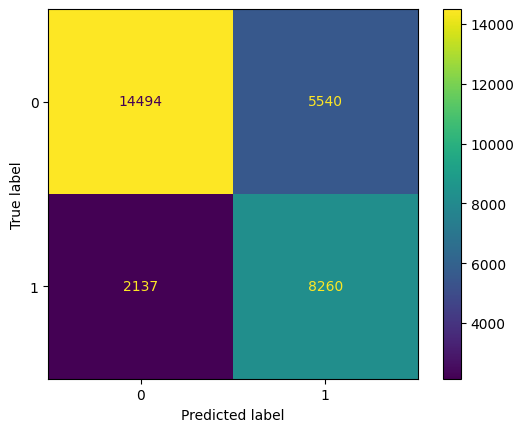

In [17]:
print("DT")
cm = confusion_matrix(y_test, dt_preds)

cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])

cm_display.plot()

RF


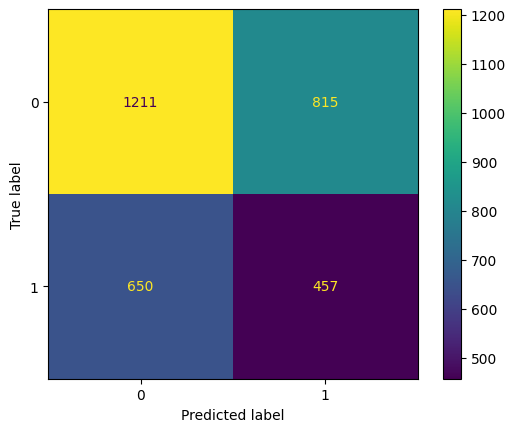

In [13]:
print("RF")
cm = confusion_matrix(y_test, rf_preds)

cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])

cm_display.plot()

In [27]:
X_transform = scaler.transform(X)

In [28]:
preds = (mlp.predict(X_transform) >= 0.5).astype(int)

  23/3860 [..............................] - ETA: 8s   

2024-09-05 13:15:13.990318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3860/3860 [==============================] - 5s 1ms/step


In [31]:
preds.shape

(123518, 1)

In [33]:
dec_to_hex = lambda x : hex(int(x))[2:]

In [40]:
X['Label'] = y
X['Predicted'] = preds
X['IAT'] = X['IAT'] * 1e6 
X['ID_HEX'] = X['ID'].apply(dec_to_hex)

In [41]:
X

,ID,DLC,Payload,IAT,Label,Predicted,ID_HEX
0,848.0,8.0,3.716925e+17,0.000000e+00,0.0,0,350
1,704.0,8.0,1.441152e+18,2.210140e+26,0.0,0,2c0
2,1072.0,8.0,0.000000e+00,5.538464e+26,0.0,1,430
3,1201.0,8.0,0.000000e+00,2.379417e+26,0.0,0,4b1
4,497.0,8.0,0.000000e+00,2.481937e+26,0.0,0,1f1
...,...,...,...,...,...,...,...
123513,608.0,8.0,3.202177e+18,2.379417e+26,0.0,0,260
123514,672.0,8.0,1.177723e+14,2.360344e+26,0.0,0,2a0
123515,809.0,8.0,9.779705e+18,2.300739e+26,0.0,0,329
123516,880.0,8.0,9.851624e+15,2.470016e+26,0.0,0,370


In [37]:
dec_to_hex(848.0)

'350'

In [45]:
X['IAT'].iloc[1:]

1         2.210140e+26
2         5.538464e+26
3         2.379417e+26
4         2.481937e+26
5         2.479553e+26
              ...     
123513    2.379417e+26
123514    2.360344e+26
123515    2.300739e+26
123516    2.470016e+26
123517    2.369881e+26
Name: IAT, Length: 123517, dtype: float64

In [15]:
1e6/1000000

1.0